# Statistics Project #1 - Linear Mixed Modeling
***

## Introduction
***

**Description**: Using data from an __[*M. tuberculosis* proteomics study](https://doi.org/10.1016/j.chom.2015.06.001)__, this script creates a linear mixed model for proteins in five different subsystems with similar sample sizes (Central carbon metabolism, Nucleotide metabolism, Respiration, Ribosome, Vitamine and co-factor metabolism). <br>
<br>
The linear mixed model is used to evaluate: <br>
(1) **Fixed effects**: Do protein molecular weight (MW) and stage of infection (Day) significantly affect the mass spec. measurement of absolute protein concentration ([protein])? <br>
<br>
(2) **Random effects**: Are the fixed effects influenced by a protein's subsystem (SS) (i.e. Does subsystem classification explain some degree of variation in the data)? <br>
<br>
**Hypothesis: A protein's molecular weight and the stage of infection are significant factors in determining the absolute [protein] of *M. tuberculosis* cells.** <br>
- In particular, lighter proteins tend to be at a higher [protein] because the cell expends less energy on their biosynthesis. <br>
- Also, the dormancy phase (Day 5-20) of infection will have a lower [protein] than the growth phase (Day 0-5) and reaeration phase (Day 20+) because cells are less metabolically active during dormancy. <br>
- MW and Day are not expected to interact, thus an additive model will be used. <br>

**Why Linear Mixed Modeling?** <br>
Uses all data (more degress of freedom and greater power), accounts for correlations, estimates fewer parameters, avoids problems with multiple comparisons --> more accurate model
- Because we are using decimal data, Poisson modeling is out of the question (integer data only) <br>

**Original Study**
- 2,023 quantified proteins
- three biological reps (1-3) & one technical rep (3b) per timepoint
- 6 timepoints: two per growth, dormancy, and reaeration phases 
- total measurements: 2,023 x 4 x 6 = 48,576

**This Project**
- amount of data reduced to make statistical comparisons practical
- three biological reps in only 5/14 subsystems used; all 6 timepoints used
- total measurements: 276 x 3 x 6 = 4,968

## Analysis
***
### Loads libraries, clears global environment, sets working directory, and sizes all plots

In [1]:
library(tidyverse)
library(readxl)
library(ggtext)
library(cowplot)
library(nlme)
library(lme4)
library(car)

rm(list = ls())

setwd('./')

options(repr.plot.width=6, repr.plot.height=4)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘nlme’

The following object is masked from ‘package:dplyr’:

    collapse

Loading required package: Matrix

Attaching package: ‘Matrix’

The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Attaching package: ‘lme4’

The following object is masked from ‘package:nlme’:

    lmList

Loading required package: carData
Registered S3 methods overwritten by 'car':
  method                          from
  influence.merMod                lme4
  cooks.distance.influence.merMod lme4
  dfbeta.influence.merMod         lme4
  dfbetas.influence.merMod        lme4

Attaching

### Loads absolute protein abundances, renames columns, and displays all subsystems with counts

In [2]:
file_name <- 'data/proteomics_TB_absolute.xlsx'

proteins <- read_excel(file_name, sheet='protein_abs', skip=1)

proteins <- proteins %>%
  rename(d00_r1=`d00...6`, d00_r2=`d00...7`,
         d00_r3=`d00...8`, d00_r3b=`d00...9`,
         d05_r1=`d05...10`, d05_r2=`d05...11`,
         d05_r3=`d05...12`, d05_r3b=`d05...13`,
         d10_r1=`d10...14`, d10_r2=`d10...15`,
         d10_r3=`d10...16`, d10_r3b=`d10...17`,
         d20_r1= `d20...18`, d20_r2=`d20...19`,
         d20_r3=`d20...20`, d20_r3b=`d20...21`,
         d20.6_r1=`d20+06h...22`, d20.6_r2=`d20+06h...23`,
         d20.6_r3=`d20+06h...24`, d20.6_r3b=`d20+06h...25`,
         d20.48_r1=`d20+48h...26`, d20.48_r2=`d20+48h...27`,
         d20.48_r3=`d20+48h...28`, d20.48_r3b=`d20+48h...29`,
         SS ='Functional annotation',
         MW='Molecular weight (g/mol)')

proteins$SS <- as.factor(proteins$SS)

proteins %>% count(SS, sort=TRUE)

New names:
* d00 -> d00...6
* d00 -> d00...7
* d00 -> d00...8
* d00 -> d00...9
* d05 -> d05...10
* ...


SS,n
Other,649
Conserved hypotheticals,452
Unknown,221
Lipid metabolism,158
Amino acid metabolism,101
Regulatory,95
Vitamine and co-factor metabolism,68
Central carbon metabolism,60
Nucleotide metabolism,56
Ribosome,47


### Selects five subsystems with similar sample sizes (~50) and calculates average [protein] for each timepoint

In [3]:
five_SS <- filter(proteins, SS == 'Central carbon metabolism' |
                            SS == 'Nucleotide metabolism' |
                            SS == 'Respiration' |
                            SS == 'Ribosome' |
                            SS == 'Vitamine and co-factor metabolism')

# r3b not included in avg. since it is a technical rep for method reproducibility
five_SS_avgs <- mutate(five_SS,
                       d00_avg = (d00_r1+d00_r2+d00_r3)/3,
                       d05_avg = (d05_r1+d05_r2+d05_r3)/3,
                       d10_avg = (d10_r1+d10_r2+d10_r3)/3,
                       d20_avg = (d20_r1+d20_r2+d20_r3)/3,
                       d20.25_avg = (d20.6_r1+d20.6_r2+d20.6_r3)/3,
                       d22_avg = (d20.48_r1+d20.48_r2+d20.48_r3)/3)

# pivots all abd. rows into a single column
five_SS_avgs_pvt <- five_SS_avgs %>%
  dplyr::select(SS, MW, d00_avg, d05_avg, d10_avg,
                d20_avg, d20.25_avg, d22_avg) %>% 
  pivot_longer(cols=d00_avg:d22_avg, names_to='Day')

five_SS_avgs_pvt$Day <- as.factor(five_SS_avgs_pvt$Day)

SS_md_mn_sd_se <- five_SS_avgs_pvt %>% group_by(SS) %>%
    summarise(medianAbd = median(value),
              meanAbd = mean(value),
              sdAbd = sd(value),
              n = n(), seAbd = sd(value)/sqrt(n()))

SS_md_mn_sd_se

`summarise()` ungrouping output (override with `.groups` argument)


SS,medianAbd,meanAbd,sdAbd,n,seAbd
Central carbon metabolism,506.8171,888.4001,993.8391,360,52.37992
Nucleotide metabolism,229.6393,339.5663,357.3014,336,19.49239
Respiration,293.2173,869.8699,1462.5410,270,89.00741
Ribosome,1065.1719,1356.4873,1074.7549,282,64.00072
Vitamine and co-factor metabolism,145.8419,308.4159,570.3478,408,28.23642


### Exploratory Plot #1: Box plot with 95% confidence intervals
Can we visually see that subsystem has some affect on average [protein]?

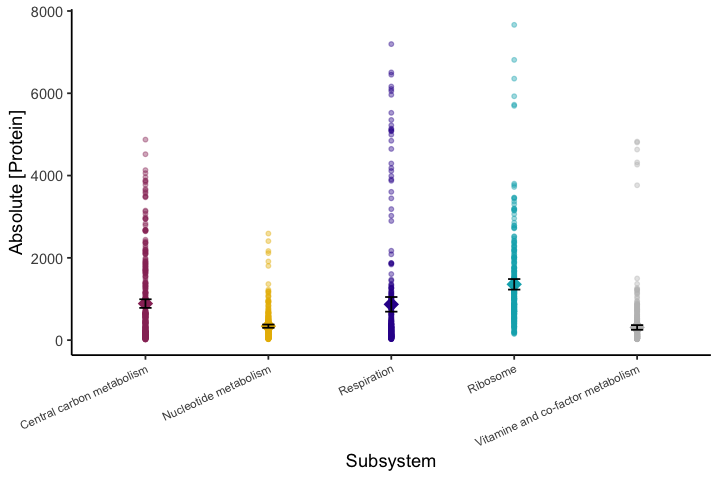

In [4]:
ggplot() +
  geom_point(five_SS_avgs_pvt, mapping=aes(x=SS, y=value, colour=SS),
             size=1, alpha=0.4) +
  geom_point(SS_md_mn_sd_se, mapping=aes(x=SS, y=meanAbd, colour=SS),
             size=4, shape=18) +
  geom_errorbar(SS_md_mn_sd_se,
                mapping=aes(x=SS,
                            ymin=meanAbd - 2*seAbd,
                            ymax=meanAbd + 2*seAbd), width=0.1) +
  scale_color_manual(values = c('#993366', '#E7B800', '#330099',
                                '#00AFBB', 'grey')) +
  xlab('Subsystem') + ylab('Absolute [Protein]') + 
  theme_classic() +
  theme(legend.position='none',
        axis.text.x = element_text(angle=25, hjust=1, size=7))

**Analysis:** It looks like average [protein] does differ between some subsystems (e.g. Central carbon metabolism and Nucleotide metabolism), but let's run an ANOVA to be sure.

### Formal statistical test (ANOVA) to determine if subsystem has a significant affect on average [protein].
Log-10 transformation performed so residuals are more homoscedastic and normally distributed.

In [5]:
anova(lm(log10(value) ~ SS, data=five_SS_avgs_pvt))

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
SS,4,124.7368,31.184204,143.5162,2.234651e-105
Residuals,1651,358.7408,0.217287,NA,NA


**Analysis**: We can reject the Null hypothesis that there is no difference in average [protein] between subsystems (F = 143.5, df = 4,1651, p-value < 0.0001).
- This suggests that proteins are correlated within each subsystem (non-independent) and justifies subsystem as a random factor.

### Exploratory Plot #2: Scatterplot of [protein] by day, colored by subsystem
Can we visually see that stage of infection (Day) has some affect on average absolute [protein]?

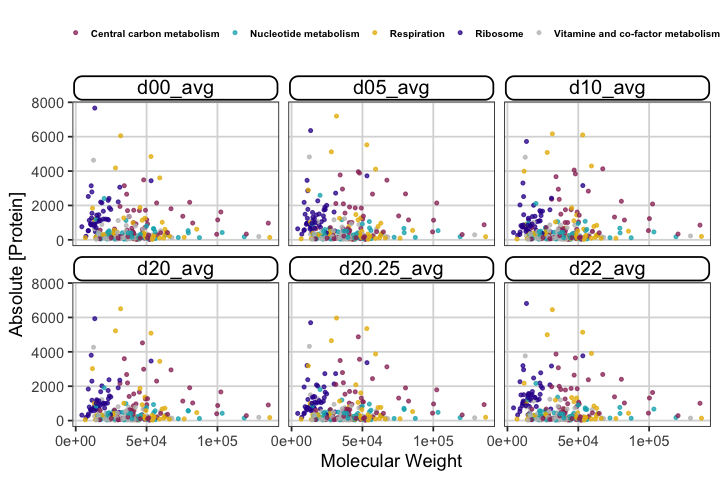

In [6]:
five_SS_avgs_pvt$Day <- as.factor(five_SS_avgs_pvt$Day)

ggplot(five_SS_avgs_pvt, aes(x=MW, y=value, colour=SS)) +
  geom_point(alpha=0.75, size=0.75) +
  facet_wrap(~ Day) + xlab('Molecular Weight') + ylab('Absolute [Protein]') +
  labs(color='') +  # changes legend name
  scale_color_manual(values = c('#993366', '#00AFBB', '#E7B800',
                                '#330099', 'grey')) +
  theme_bw() + background_grid() +
  theme(legend.title=element_text(size=1, face='bold'),
        legend.text=element_text(size=6, face='bold'),
        legend.position='top', strip.background=element_blank(),
        strip.text=element_textbox(size=12, color='black', fill='white',
                                   box.color='black', halign=0.5, linetype=1,
                                   r=unit(5, 'pt'), width=unit(1, 'npc'),
                                   padding=margin(2, 0, 1, 0),
                                   margin=margin(1, 1, 1, 1)))

**Analysis**: The scatter of points for each subsystem seems to follow the same pattern between timepoints. For example, Ribosome proteins (the purple data points) have smaller molecular weights (most are less than 5E+04 g/mol) and have larger absolute [protein] (many are above ~500 copies/cell). This indicates that stage of infection (Day) may not be a significant factor in determining absolute [protein]. We will see shortly via lme(). <br>
<br>
Note: The above plots are simply a way to visualize the data. I won't be running multiple regressions either since 72 parameter estimates would be generated (2 paramters x 6 Days x 6 SS) plus the sample size would be reduced from 1659 to 276 and the error would increase due to multiple hypothesis testing.

### Scales molecular weight then assesses model residuals for homoscedasticity and normal distribution
Scaling (mean = 0 and stnd dev. = 1) done to improve model convergence.

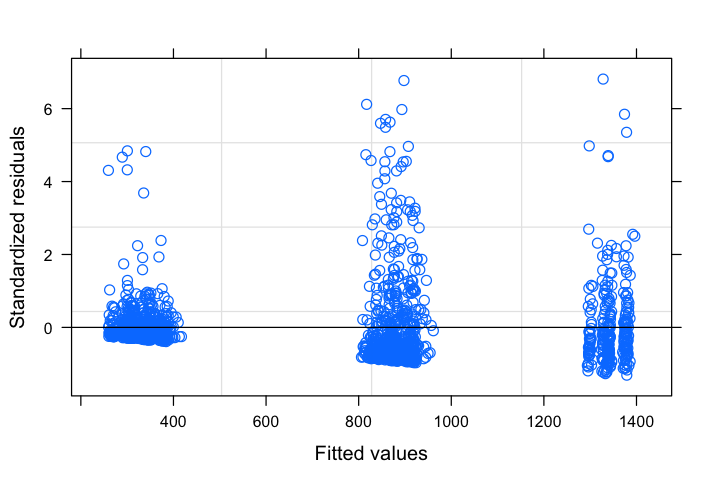

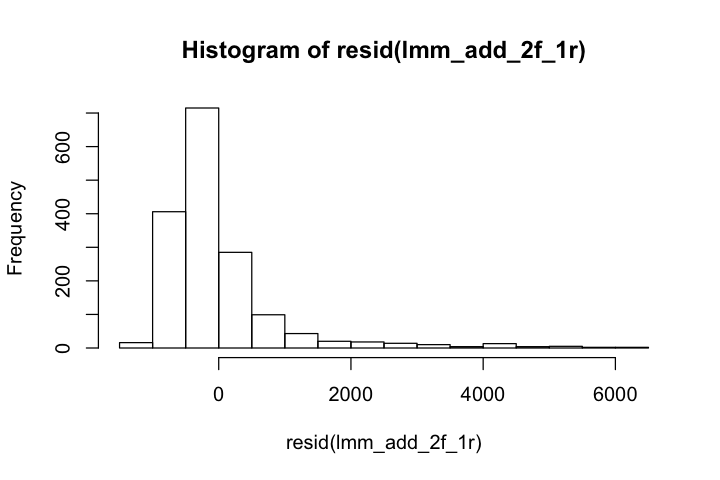

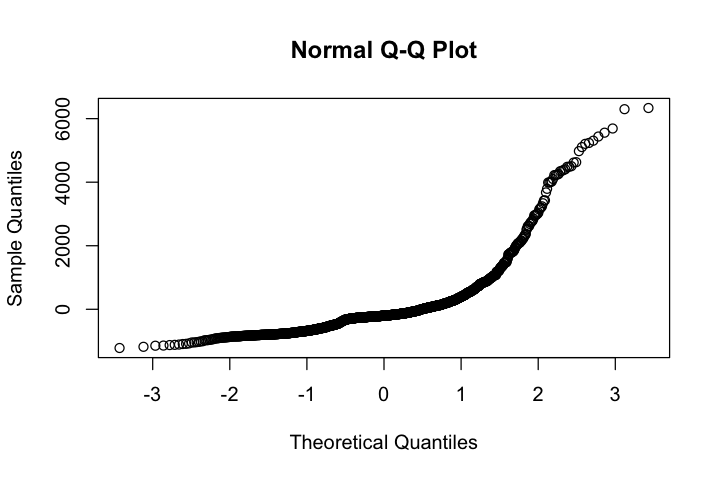

In [7]:
five_SS_avgs_pvt$MW <- scale(five_SS_avgs_pvt$MW)

# MW and Day not expected to interact, thus an additive model used (MW + Day)
# ML: maximizes log-likelihood (not REML for restricted)
lmm_add_2f_1r <- lme(value ~ MW + Day, random = ~1|SS,
                     method='ML', na.action=na.omit, data=five_SS_avgs_pvt)

plot(lmm_add_2f_1r)  # heteroscedastic; looks like residuals cluster around 0
hist(resid(lmm_add_2f_1r))  # non-normal dist.; R-skewed
qqnorm(resid(lmm_add_2f_1r))  # heteroscedastic; S-like = variance is unequal

### Log10-transforms absolute [protein] to see if residuals are more homoscedastic and normally distributed

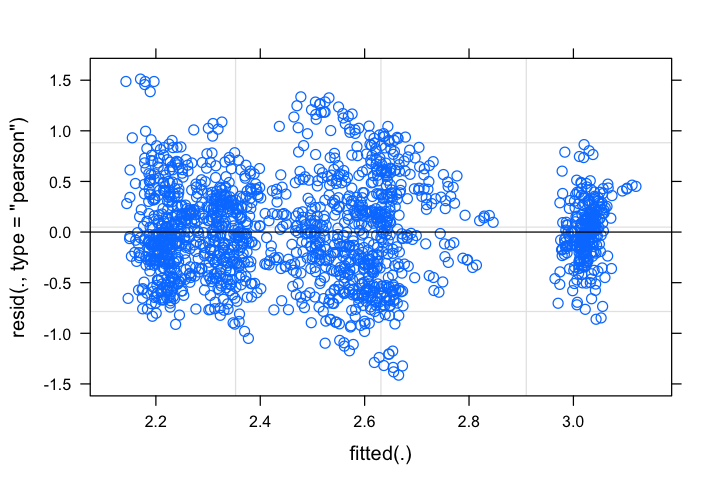

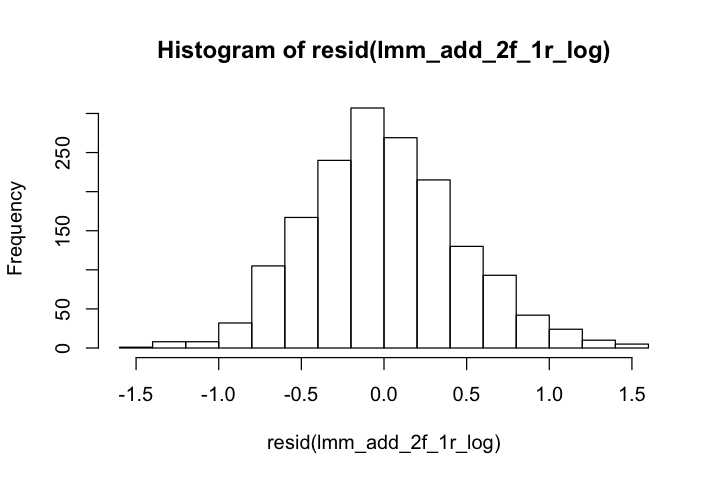

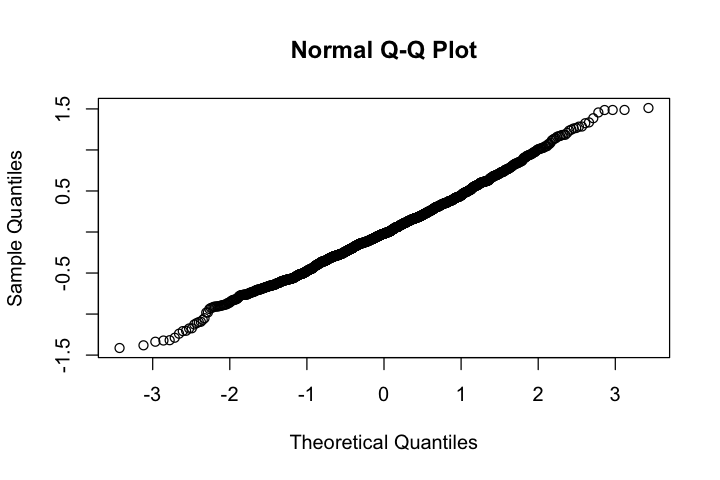

In [8]:
# lme(): no random effect variance for summary() --> lmer() used instead
lmm_add_2f_1r_log <- lmer(log10(value) ~ MW + Day + (1|SS),
                          data=five_SS_avgs_pvt)

plot(lmm_add_2f_1r_log)  # homoscedastic; random scatter
hist(resid(lmm_add_2f_1r_log))  # wow, log10 makes data more normally dist.
qqnorm(resid(lmm_add_2f_1r_log))  # homoscedastic; variance is equal throughout

**Analysis:** Residuals meet assumptions much better with log-10 transformation (night and day). Therefore, log-10 transformed data will be used in all subsequent analyses.

In [9]:
Anova(lmm_add_2f_1r_log, type='II')  # Chi-squared test (NOT t-test)

# no need to change contrasts since order of levels doesn't matter for Type II Wald Chi-square tests

,Chisq,Df,Pr(>Chisq)
MW,12.71042,1,0.0003636228
Day,2.24292,5,0.8146128389


**Analysis:** In this *M. tuberculosis* study profiling proteomic expression at different stages of infection, a linear mixed model was used to perform Type II Wald chisquare tests. The chisquare tests revealed that the average molecular weight (MW) for proteins in a given subsystem significantly affect average absolute [protein] (Chisq = 12.71, df = 1, p-value < 0.001) whereas the stage of infection (Day) does not (Chisq = 2.24, df = 5, p-value = 0.815).
- The non-significance of stage of infection on average absolute [protein] was surprising because different proteins are expressed at different stages of infection, which would likely alter [protein]. 

### Calculates statistics for random and fixed effects

In [10]:
summary(lmm_add_2f_1r_log)  # lmer summary(): no p-value returned, but can be calculated

Linear mixed model fit by REML ['lmerMod']
Formula: log10(value) ~ MW + Day + (1 | SS)
   Data: five_SS_avgs_pvt

REML criterion at convergence: 2214.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.0408 -0.6597 -0.0431  0.6492  3.2509 

Random effects:
 Groups   Name        Variance Std.Dev.
 SS       (Intercept) 0.1057   0.3251  
 Residual             0.2161   0.4648  
Number of obs: 1656, groups:  SS, 5

Fixed effects:
                Estimate Std. Error t value
(Intercept)    2.5601303  0.1480668  17.290
MW             0.0460267  0.0129101   3.565
Dayd05_avg     0.0170058  0.0395690   0.430
Dayd10_avg    -0.0089747  0.0395690  -0.227
Dayd20_avg    -0.0368662  0.0395690  -0.932
Dayd20.25_avg -0.0008134  0.0395690  -0.021
Dayd22_avg     0.0096458  0.0395690   0.244

Correlation of Fixed Effects:
            (Intr) MW     Dyd05_ Dyd10_ Dyd20_ D20.25
MW           0.002                                   
Dayd05_avg  -0.134  0.000                            
Dayd10_avg  

**Analysis**<br>
Random Effects: Subsystem as a random factor explains 33% of the residual/unexplained variation (0.1057/(0.1057 + 0.2161).
- Most variance, 67%, is explained by fixed effects.

Fixed Effects: <br>
<br>
**Molecular Weight y-Intercept = 2.56,  Slope = 0.046 (SE = 0.013)**
- Slope: as MW increases 1 stnd. dev., [protein] increaes by 0.046 stnd. dev.

**Molecular Weight Correlation = 0.002**
- Accounting for differences in subsystems, there is a significant, positive correlation of 0.002 between  molecular weight and average absolute [protein] for this subset of proteins (t = 3.565, p-value < 0.001). *(p-value calculated manually)*
- A negative correlation for MW and [protein] would match my hypothesis since smaller MWs usually produce more mass spec. signal and therefore higher [protein].

*Day y-intercepts: not considered since they are not significant*
## Conclusion
***
**Day does not significantly change [protein] slopes or intercepts. Subsystem y-intercepts differ across Days, justifying it's use as a random factor capable of producing residual variation. As for molecular weight, it significantly affects average absolute [protein] (t = 3.565, p-value < 0.001). In fact, the average, log10-transformed y-intercept is 2.56 protein copies/cell and the average slope is 0.046 g/mol. This means that for every increase in molecular weight corresponding to 1 stnd. deviation, the increase in [protein] corresponds to 0.046 of a stnd. deviation.**
### Final Plot: Scatterplot with slopes and y-intercepts

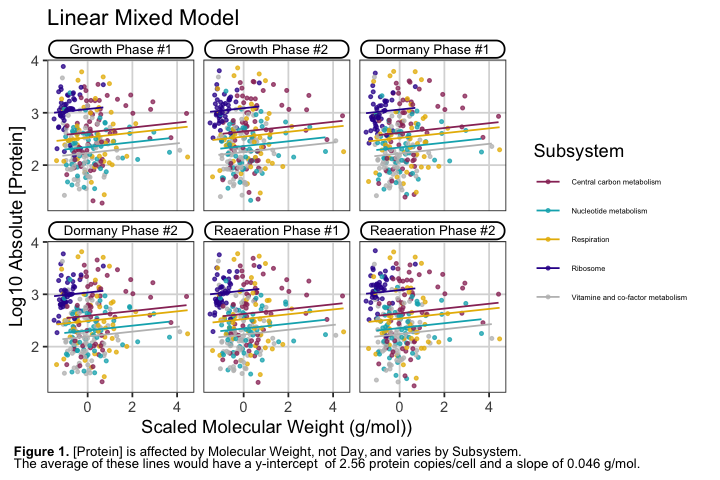

In [11]:
five_SS_avgs_pvt$Day <- dplyr::recode(five_SS_avgs_pvt$Day,
                                      'd00_avg'='Growth Phase #1',
                                      'd05_avg'='Growth Phase #2',
                                      'd10_avg'='Dormany Phase #1',
                                      'd20_avg'='Dormany Phase #2',
                                      'd20.25_avg'='Reaeration Phase #1',
                                      'd22_avg'='Reaeration Phase #2')

ggplot(five_SS_avgs_pvt, aes(x=MW, y=log10(value), colour=SS)) +
  geom_point(alpha=0.75, size=0.75) + facet_wrap(~ Day) +
  xlab('Scaled Molecular Weight (g/mol))') + ylab('Log10 Absolute [Protein]') +
  labs(title='Linear Mixed Model', color='Subsystem',
       caption=(paste0('**Figure 1.** [Protein] is affected by Molecular Weight, not Day, and varies by Subsystem. <br>',
                       ' The average of these lines would have a y-intercept of 2.56 protein copies/cell and a slope of 0.046 g/mol.'))) +
  geom_line(data = cbind(five_SS_avgs_pvt,
                         pred = predict(lmm_add_2f_1r_log)), aes(y = pred)) +
  scale_color_manual(values = c('#993366', '#00AFBB', '#E7B800',
                                '#330099', 'grey')) +
  theme_bw() + background_grid() +
  theme(legend.text=element_text(size=4.5),
        plot.caption=element_markdown(size=8, hjust=0.2, halign=0),
        strip.background=element_blank(),
        strip.text=element_textbox(size=8, color='black', fill='white',
                                   box.color='black', halign=0.5, linetype=1,
                                   r=unit(5, 'pt'), width=unit(1, 'npc'),
                                   padding=margin(2, 0, 1, 0),
                                   margin=margin(1, 1, 1, 1)))